In [1]:
# if open from google colab, run this command
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/sales-prediction-gru/ipynb

Mounted at /content/drive
/content/drive/MyDrive/Github/sales-prediction-gru/ipynb


In [2]:
import os 
print(os.listdir("../data"))

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import pylab as plt
import matplotlib.dates as mdates
plt.rcParams['figure.figsize'] = (15.0, 8.0)
import seaborn as sns

from sklearn.metrics import mean_squared_error
from numpy import sqrt

['sales_train.csv', 'test.csv', 'items.csv', 'sample_submission.csv', 'fakta_penjualan_barangg_202112081901.csv', 'dimensi_barang_202112081905.csv', 'fakta_penjualan_unv_202112091006.csv', 'item_categories.csv', 'shops.csv']


In [3]:
df = pd.read_csv('../data/fakta_penjualan_unv_202112091006.csv')

df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,nonota,hari,bulan,tahun,namabarang,satuan,qty,hargajual,hargabeli,hargajual2,kodejenis,jenis,barcode,keuntungan,kodecabang,cabang
0,﻿021511000048,2,11,2015,LIFEBUOY SHP HAIRFALL 170ML,PCS,1.0,13450.0,12700.0,13450.0,10304,Hair Care (4),8999999033132,NaN,NaN,NaN
1,021511000048,2,11,2015,PEPSODENT PGB SUGAR ACID 180GR,PCS,1.0,12000.0,11550.0,12000.0,10307,Oral Care (7),8999999041953,NaN,NaN,NaN
2,021511000048,2,11,2015,LIFEBUOY TS MILD CARE 144*110G,PCS,5.0,3370.0,3225.0,3370.0,10301,Bath Care (1),8999999045944,NaN,NaN,NaN
3,021511000050,2,11,2015,CLOSE UP GREEN/MENTHOL 48*65GR,PCS,1.0,5450.0,5200.0,5450.0,10307,Oral Care (7),8999999707835,NaN,NaN,NaN
4,021511000057,2,11,2015,CITRA PEARLY UV SERUM 8*3*180M,PCS,1.0,22155.0,21300.0,22155.0,10308,Skin Care (8),8999999037918 - 26/06/2020,NaN,NaN,NaN


In [4]:
train_clean = df.drop(['nonota', 'namabarang', 'satuan', 'hargajual', 'hargabeli', 'hargajual2', 'kodejenis', 'jenis', 'keuntungan', 'kodecabang', 'cabang'], axis=1)

In [5]:
train_clean['barcode'] = train_clean['barcode'].astype(str).str[:13]

In [6]:
train_clean['qty'] = train_clean['qty'].astype(int)
train_clean['barcode'] = train_clean['barcode'].astype('int64')
display(train_clean.head())
display(train_clean.info())

,hari,bulan,tahun,qty,barcode
0,2,11,2015,1,8999999033132
1,2,11,2015,1,8999999041953
2,2,11,2015,5,8999999045944
3,2,11,2015,1,8999999707835
4,2,11,2015,1,8999999037918


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844679 entries, 0 to 1844678
Data columns (total 5 columns):
 #   Column   Dtype
---  ------   -----
 0   hari     int64
 1   bulan    int64
 2   tahun    int64
 3   qty      int64
 4   barcode  int64
dtypes: int64(5)
memory usage: 70.4 MB


None

In [7]:
test = train_clean[train_clean['tahun']==2019]
test.head()

,hari,bulan,tahun,qty,barcode
1096038,1,1,2019,1,8999999407919
1096039,1,1,2019,2,8999999500399
1096040,1,1,2019,1,8999999003067
1096041,1,1,2019,2,8999999045579
1096042,1,1,2019,1,8992747180225


In [8]:
years = [2015, 2016, 2017, 2018]
train_clean = train_clean[train_clean.tahun.isin(years)]

In [9]:
def column_to_date(data):
    # create date column from hari, bulan, tahun column
    cols = ["hari","bulan","tahun"]
    data['date'] = data[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
    
    # drop hari, bulan, tahun column
    data = data.drop(['hari', 'bulan', 'tahun'], axis=1)
    
    # transformn date column to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    return data

In [10]:
test = column_to_date(test)
test.head()

,qty,barcode,date
1096038,1,8999999407919,2019-01-01
1096039,2,8999999500399,2019-01-01
1096040,1,8999999003067,2019-01-01
1096041,2,8999999045579,2019-01-01
1096042,1,8992747180225,2019-01-01


In [11]:
print(f"Min date from data set: {test['date'].min().date()}")
print(f"Max date from data set: {test['date'].max().date()}")

Min date from data set: 2019-01-01
Max date from data set: 2019-12-31


In [12]:
test = test.drop(['qty', 'date'], axis=1)
test.head()

,barcode
1096038,8999999407919
1096039,8999999500399
1096040,8999999003067
1096041,8999999045579
1096042,8992747180225


In [13]:
train_clean = column_to_date(train_clean)
train_clean.head()

,qty,barcode,date
0,1,8999999033132,2015-02-11
1,1,8999999041953,2015-02-11
2,5,8999999045944,2015-02-11
3,1,8999999707835,2015-02-11
4,1,8999999037918,2015-02-11


In [14]:
print(f"Min date from data set: {train_clean['date'].min().date()}")
print(f"Max date from data set: {train_clean['date'].max().date()}")

Min date from data set: 2015-01-12
Max date from data set: 2018-12-31


In [15]:
train_clean['month_yr'] = train_clean['date'].apply(lambda x: x.strftime('%m-%y')).astype(str)

train_clean['month_yr'] = train_clean['month_yr'].map({'01-15':0,'02-15':1,'03-15':2,'04-15':3,'05-15':4,'06-15':5,'07-15':6,'08-15':7,'09-15':8,'10-15':9,'11-15':10,'12-15':11,
                                          '01-16':12,'02-16':13,'03-16':14,'04-16':15,'05-16':16,'06-16':17,'07-16':16,'08-16':19,'09-16':20,'10-16':21,'11-16':22,'12-16':23,
                                          '01-17':24,'02-17':25,'03-17':26,'04-17':27,'05-17':28,'06-17':29,'07-17':30,'08-17':31,'09-17':32,'10-17':33,'11-17':34,'12-17':35,
                                          '01-18':36,'02-18':37,'03-18':38,'04-18':39,'05-18':40,'06-18':41,'07-18':42,'08-18':43,'09-18':44,'10-18':45,'11-18':46,'12-18':47})

train_clean.head()

,qty,barcode,date,month_yr
0,1,8999999033132,2015-02-11,1
1,1,8999999041953,2015-02-11,1
2,5,8999999045944,2015-02-11,1
3,1,8999999707835,2015-02-11,1
4,1,8999999037918,2015-02-11,1


In [16]:
train_clean['month_yr'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0, 12, 13, 14, 15, 16,
       17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

In [17]:
train_clean = train_clean.drop(['date'], axis = 1)
train_clean.head()

,qty,barcode,month_yr
0,1,8999999033132,1
1,1,8999999041953,1
2,5,8999999045944,1
3,1,8999999707835,1
4,1,8999999037918,1


In [18]:
# change the item count per day to item count per month by using group
train_clean = train_clean.groupby(["barcode", "month_yr"]).sum().reset_index()
train_clean = train_clean.rename(index=str, columns = {"qty":"qty_month"})
train_clean = train_clean[["barcode", "month_yr", "qty_month"]]
train_clean

,barcode,month_yr,qty_month
0,4800888137319,1,1
1,4800888137319,3,1
2,4800888137319,6,2
3,4800888137319,7,2
4,4800888137319,10,16
...,...,...,...
40103,9556126640121,12,8
40104,9556126640121,13,3
40105,9556126640121,19,1
40106,9556126640121,20,1


In [19]:
check = train_clean[["barcode","month_yr","qty_month"]]
check = check.loc[check['barcode'] == 4800888137319]
check

,barcode,month_yr,qty_month
0,4800888137319,1,1
1,4800888137319,3,1
2,4800888137319,6,2
3,4800888137319,7,2
4,4800888137319,10,16
5,4800888137319,11,21
6,4800888137319,12,15
7,4800888137319,13,23
8,4800888137319,14,23
9,4800888137319,15,12


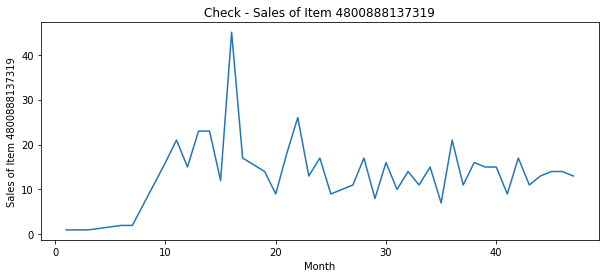

In [20]:
plt.figure(figsize=(10,4))
plt.title('Check - Sales of Item 4800888137319')
plt.xlabel('Month')
plt.ylabel('Sales of Item 4800888137319')
plt.plot(check["month_yr"],check["qty_month"]);

In [21]:
month_list=[i for i in range(47+1)]
barcode = []
for i in range(47+1):
    barcode.append(4800888137319)
months_full = pd.DataFrame({'barcode':barcode, 'month_yr':month_list})
months_full

,barcode,month_yr
0,4800888137319,0
1,4800888137319,1
2,4800888137319,2
3,4800888137319,3
4,4800888137319,4
5,4800888137319,5
6,4800888137319,6
7,4800888137319,7
8,4800888137319,8
9,4800888137319,9


In [22]:
sales_47month = pd.merge(check, months_full, how='right', on=['barcode','month_yr'])
sales_47month = sales_47month.sort_values(by=['month_yr'])
sales_47month.fillna(0.00,inplace=True)
sales_47month

,barcode,month_yr,qty_month
0,4800888137319,0,0.0
1,4800888137319,1,1.0
2,4800888137319,2,0.0
3,4800888137319,3,1.0
4,4800888137319,4,0.0
5,4800888137319,5,0.0
6,4800888137319,6,2.0
7,4800888137319,7,2.0
8,4800888137319,8,0.0
9,4800888137319,9,0.0


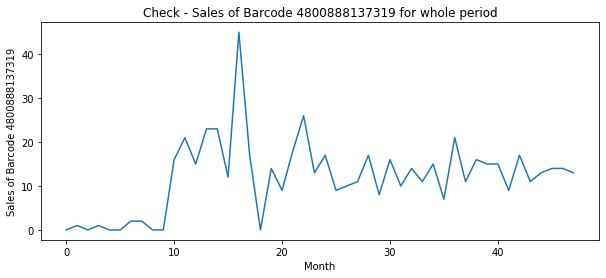

In [23]:
plt.figure(figsize=(10,4))
plt.title('Check - Sales of Barcode 4800888137319 for whole period')
plt.xlabel('Month')
plt.ylabel('Sales of Barcode 4800888137319')
plt.plot(sales_47month["month_yr"],sales_47month["qty_month"]);

In [24]:
for i in range(1,6):
    sales_47month["T_" + str(i)] = sales_47month.qty_month.shift(i)
sales_47month.fillna(0.0, inplace=True)
sales_47month

,barcode,month_yr,qty_month,T_1,T_2,T_3,T_4,T_5
0,4800888137319,0,0.0,0.0,0.0,0.0,0.0,0.0
1,4800888137319,1,1.0,0.0,0.0,0.0,0.0,0.0
2,4800888137319,2,0.0,1.0,0.0,0.0,0.0,0.0
3,4800888137319,3,1.0,0.0,1.0,0.0,0.0,0.0
4,4800888137319,4,0.0,1.0,0.0,1.0,0.0,0.0
5,4800888137319,5,0.0,0.0,1.0,0.0,1.0,0.0
6,4800888137319,6,2.0,0.0,0.0,1.0,0.0,1.0
7,4800888137319,7,2.0,2.0,0.0,0.0,1.0,0.0
8,4800888137319,8,0.0,2.0,2.0,0.0,0.0,1.0
9,4800888137319,9,0.0,0.0,2.0,2.0,0.0,0.0


In [25]:
data = sales_47month[['barcode','month_yr','T_1','T_2','T_3','T_4','T_5', 'qty_month']].reset_index()
data = data.drop(labels = ['index'], axis = 1)
data

,barcode,month_yr,T_1,T_2,T_3,T_4,T_5,qty_month
0,4800888137319,0,0.0,0.0,0.0,0.0,0.0,0.0
1,4800888137319,1,0.0,0.0,0.0,0.0,0.0,1.0
2,4800888137319,2,1.0,0.0,0.0,0.0,0.0,0.0
3,4800888137319,3,0.0,1.0,0.0,0.0,0.0,1.0
4,4800888137319,4,1.0,0.0,1.0,0.0,0.0,0.0
5,4800888137319,5,0.0,1.0,0.0,1.0,0.0,0.0
6,4800888137319,6,0.0,0.0,1.0,0.0,1.0,2.0
7,4800888137319,7,2.0,0.0,0.0,1.0,0.0,2.0
8,4800888137319,8,2.0,2.0,0.0,0.0,1.0,0.0
9,4800888137319,9,0.0,2.0,2.0,0.0,0.0,0.0


In [26]:
train_data = data[:-3]
val_data = data[-3:]
x_train, y_train = train_data.drop(["qty_month"], axis=1), train_data.qty_month
x_val, y_val = val_data.drop(["qty_month"], axis=1), val_data.qty_month

In [27]:
# x_train

In [28]:
# y_train

In [29]:
x_val.shape

(3, 7)

In [30]:
y_val

45    14.0
46    14.0
47    13.0
Name: qty_month, dtype: float64

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU, Dropout
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras import callbacks

In [32]:
# model_gru = Sequential()
# model_gru.add(GRU(15, input_shape=(1,7)))
# model_gru.add(Dense(1))

model_gru = Sequential()
model_gru.add(GRU(10, input_shape=(1, 7), return_sequences=True))
model_gru.add(GRU(6, activation='relu', return_sequences=True))
model_gru.add(GRU(1, activation='relu'))
# model_gru.add(Dropout(0.2)) 
model_gru.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
model_gru.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
model_gru.add(Dense(1))

model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
# Reshape the data between -1 and 1 and to 3D
scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_val)

In [34]:
x_train_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
x_val_resaped = x_valid_scaled.reshape((x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1]))

In [50]:
y_val

45    14.0
46    14.0
47    13.0
Name: qty_month, dtype: float64

In [36]:
early_stop = callbacks.EarlyStopping(patience = 10)
history = model_gru.fit(x_train_reshaped, y_train, validation_data=(x_val_resaped, y_val),epochs=1000, batch_size=32, verbose=2, shuffle=False, callbacks=[early_stop])
# history = model_gru.fit(x_train_reshaped, y_train, validation_data=(x_val_resaped, y_val),epochs=1000, batch_size=32, verbose=2, shuffle=False)
y_pre = model_gru.predict(x_val_resaped)

Epoch 1/1000
2/2 - 6s - loss: 215.8367 - val_loss: 186.9453 - 6s/epoch - 3s/step
Epoch 2/1000
2/2 - 0s - loss: 215.7895 - val_loss: 186.8908 - 38ms/epoch - 19ms/step
Epoch 3/1000
2/2 - 0s - loss: 215.7424 - val_loss: 186.8363 - 35ms/epoch - 18ms/step
Epoch 4/1000
2/2 - 0s - loss: 215.6953 - val_loss: 186.7818 - 37ms/epoch - 19ms/step
Epoch 5/1000
2/2 - 0s - loss: 215.6483 - val_loss: 186.7272 - 40ms/epoch - 20ms/step
Epoch 6/1000
2/2 - 0s - loss: 215.6012 - val_loss: 186.6728 - 43ms/epoch - 22ms/step
Epoch 7/1000
2/2 - 0s - loss: 215.5542 - val_loss: 186.6183 - 40ms/epoch - 20ms/step
Epoch 8/1000
2/2 - 0s - loss: 215.5072 - val_loss: 186.5639 - 36ms/epoch - 18ms/step
Epoch 9/1000
2/2 - 0s - loss: 215.4602 - val_loss: 186.5094 - 39ms/epoch - 19ms/step
Epoch 10/1000
2/2 - 0s - loss: 215.4132 - val_loss: 186.4550 - 40ms/epoch - 20ms/step
Epoch 11/1000
2/2 - 0s - loss: 215.3662 - val_loss: 186.4006 - 45ms/epoch - 22ms/step
Epoch 12/1000
2/2 - 0s - loss: 215.3192 - val_loss: 186.3462 - 37ms

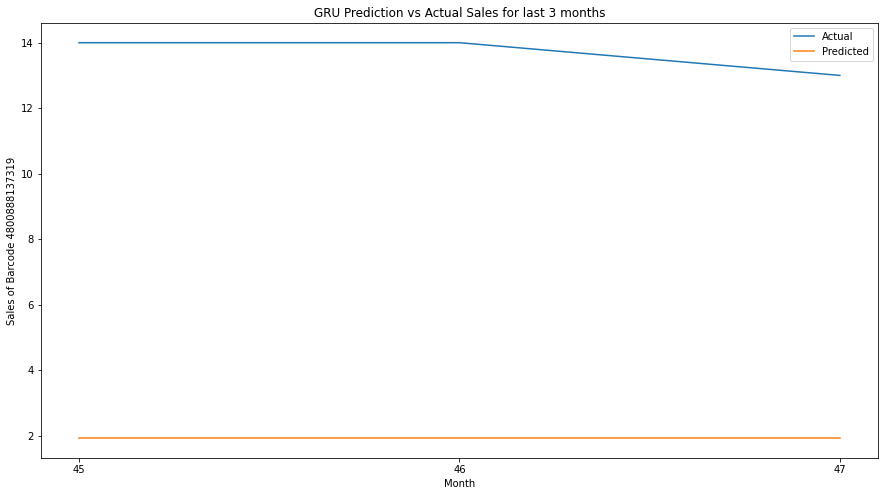

In [37]:
fig, ax = plt.subplots()
ax.plot(x_val['month_yr'], y_val, label='Actual')
ax.plot(x_val['month_yr'], y_pre, label='Predicted')
plt.title('GRU Prediction vs Actual Sales for last 3 months')
plt.xlabel('Month')
plt.xticks(x_val['month_yr'])
plt.ylabel('Sales of Barcode 4800888137319')
ax.legend()
plt.show()

In [38]:
rmse = sqrt(mean_squared_error(y_val,y_pre))
print('Val RMSE: %.3f' % rmse)

Val RMSE: 11.751


In [39]:
y_pre

array([[1.9255953],
       [1.9255953],
       [1.9255953]], dtype=float32)

In [40]:
# rumus rmse
# np.sqrt(((data_predict - labels) ** 2).mean())

# ramal penjualan di bulan desember tahun 2015, 2016, 2017, 2018 untuk meramal bulan desember 2021

# Prediction and Accuracy
# test_data= scaled_data[training_data_len-60:, :]
# x_test = []
# y_test = dataset[training_data_len:,:]
# for i in range(60,len(test_data)):
#     x_test.append(test_data[i-60:i,0])
# x_test = np.array(x_test)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
# predictions = model.predict(x_test)
# predictions = scaler.inverse_transform(predictions)
# rmse = np.sqrt(np.mean(predictions - y_test)**2)
# rmse